# 6.6 Sourcing & Analyzing Time-Series Data

### Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 

import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'KzDZZpxC8akQa_Qhyxjg'

#### Importing 'Federal Debt: Total Public Debt' from the 'Federal Reserve Economic' Data

In [7]:
# Importing Data
data = quandl.get('FRED/GFDEBTN')

In [8]:
data.head(5)

,Value
Date,
1966-01-01,320999.0
1966-04-01,316097.0
1966-07-01,324748.0
1966-10-01,329319.0
1967-01-01,330947.0


In [9]:
data.shape

(224, 1)

In [10]:
data.columns

Index(['Value'], dtype='object')

In [11]:
type(data)

pandas.core.frame.DataFrame

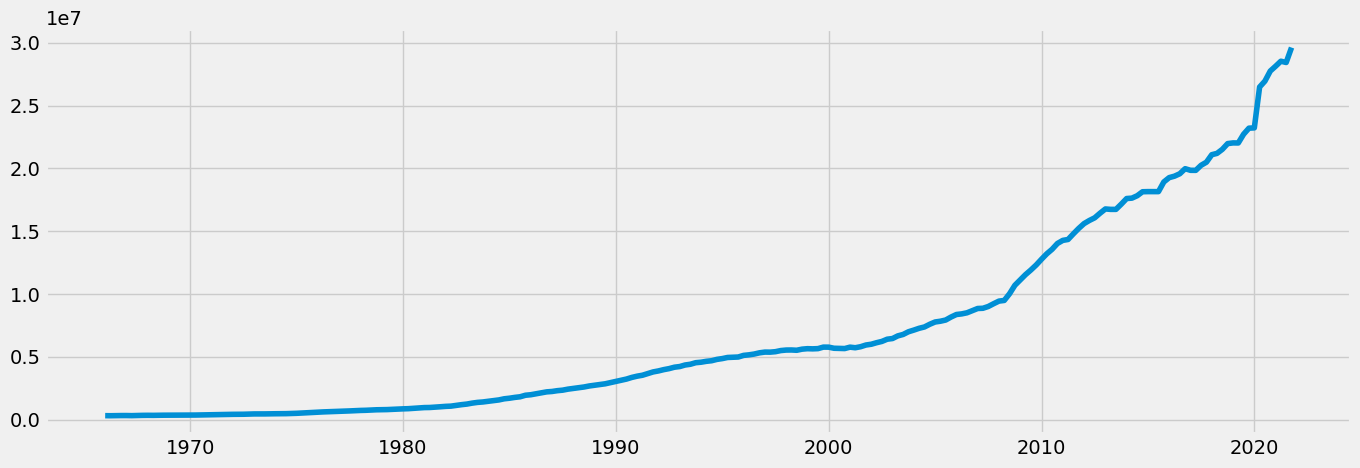

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

Cutting the 'Federal Debt: Total Public Debt' data from 1980 instead of 1966 makes it easier to focus on recent economic trends and policies. Starting from 1980 includes important events like Reaganomics, the end of the Cold War, and the rise of globalization and technology, which are important for understanding current federal debt issues.

In [13]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [14]:
data_2.head()

,Date,Value
0,1966-01-01,320999.0
1,1966-04-01,316097.0
2,1966-07-01,324748.0
3,1966-10-01,329319.0
4,1967-01-01,330947.0


In [15]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2024-06-01')]

In [16]:
data_sub.shape

(168, 2)

In [17]:
data_sub.head()

,Date,Value
56,1980-01-01,863451.0
57,1980-04-01,877614.0
58,1980-07-01,907701.0
59,1980-10-01,930210.0
60,1981-01-01,964531.0


In [18]:
# Set the 'Date' column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1980-01-01,863451.0
1980-04-01,877614.0
1980-07-01,907701.0
1980-10-01,930210.0
1981-01-01,964531.0


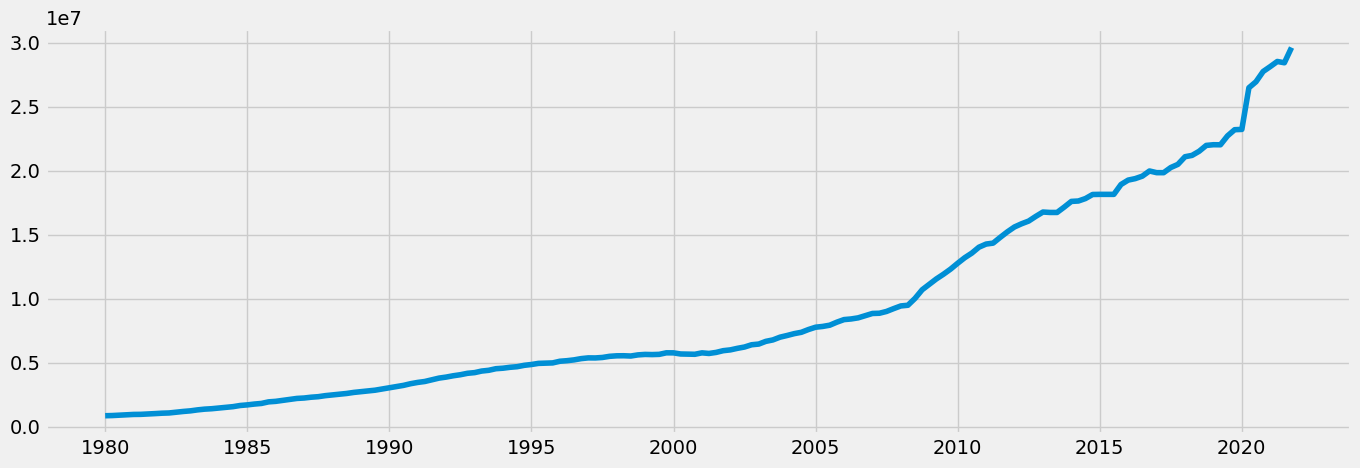

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [20]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

### Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

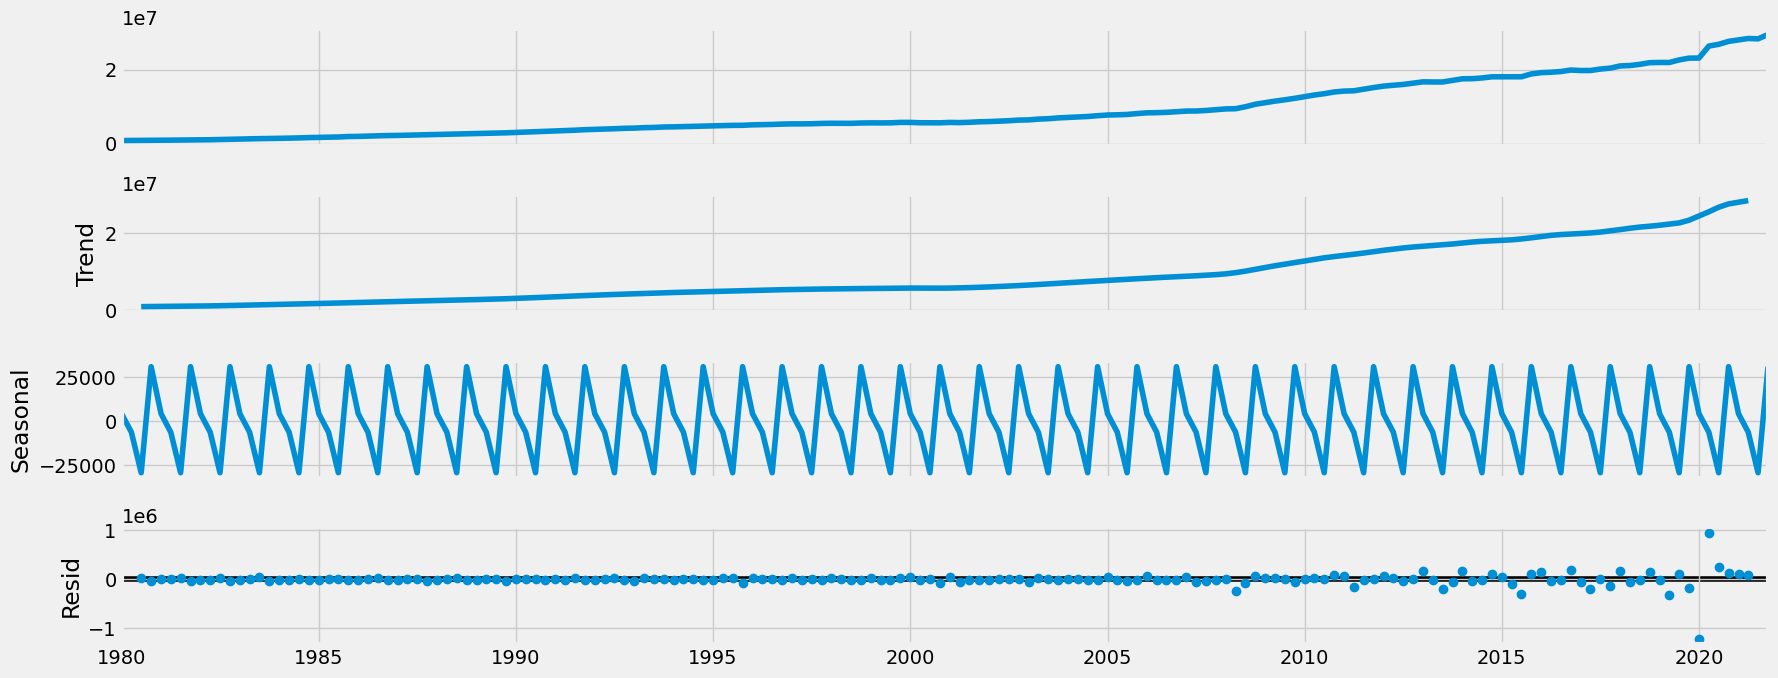

In [24]:
# Plot the separate components

decomposition.plot()
plt.show()

The decomposition shows three main components of the federal debt data from 1980 to 2024. The trend component indicates a steady increase in debt over time. The seasonal component reveals regular yearly fluctuations, suggesting a predictable pattern within each year. The residuals are relatively small and mostly centered around zero, indicating that the model fits the data well with no significant unexplained variations.

### Testing for stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.946386
p-value                          1.000000
Number of Lags Used             14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


Here, the test statistic is 2.946386, which is higher than all the critical values (-3.473830, -2.880623, -2.576945) at the 1%, 5%, and 10% levels. The p-value is 1.000000, which is much higher than 0.05. This means we fail to reject the null hypothesis (= the time series is non-stationary).

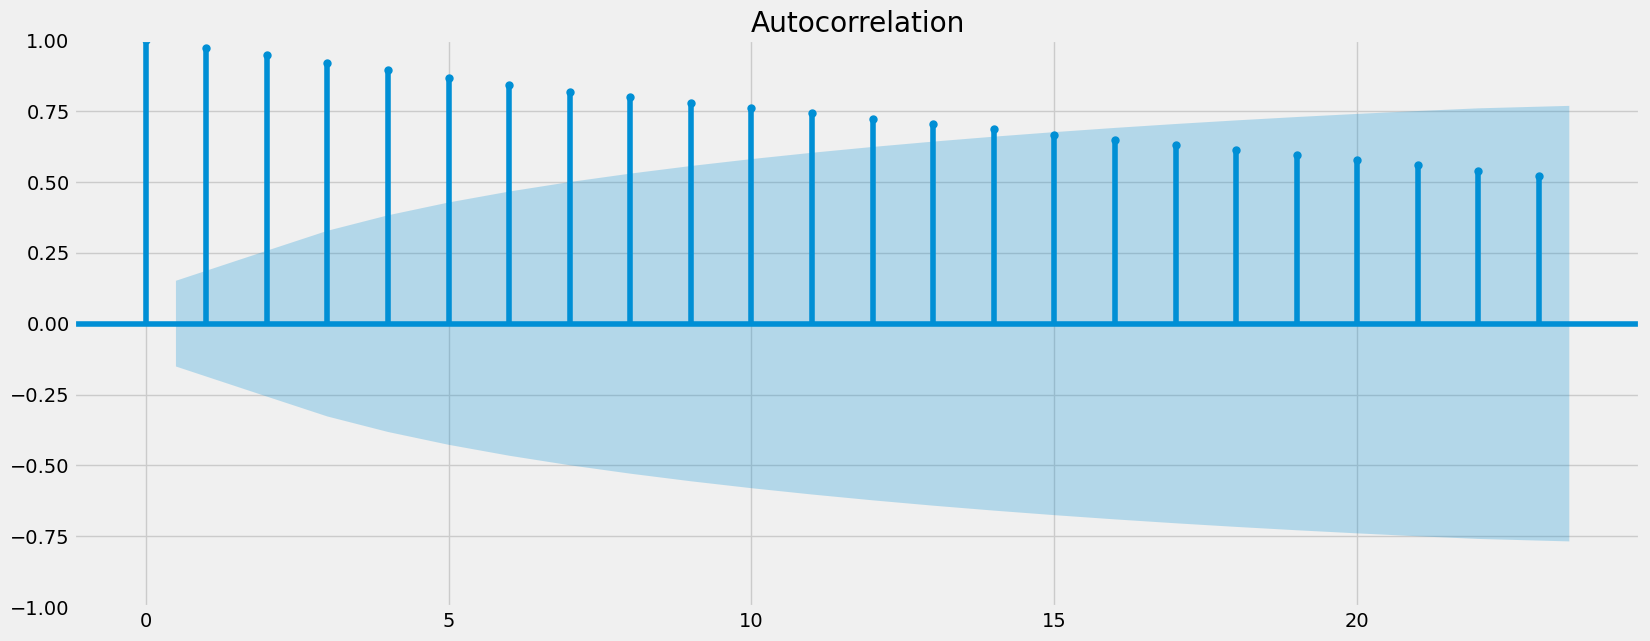

In [27]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

The autocorrelation plot shows that the data points are highly correlated with their previous values, as indicated by the bars that gradually decrease but remain significant beyond the confidence interval. This confirms the result from the Dickey-Fuller test that the series is not stationary, as a stationary series would show much less autocorrelation over time.

### Stationarizing the Total Public Debt Data

In [28]:
data_diff = data_sub - data_sub.shift(1)

In [29]:
data_diff.dropna(inplace = True)

In [30]:
data_diff.head()

,Value
datetime,
1980-04-01,14163.0
1980-07-01,30087.0
1980-10-01,22509.0
1981-01-01,34321.0
1981-04-01,6643.0


In [31]:
data_diff.columns

Index(['Value'], dtype='object')

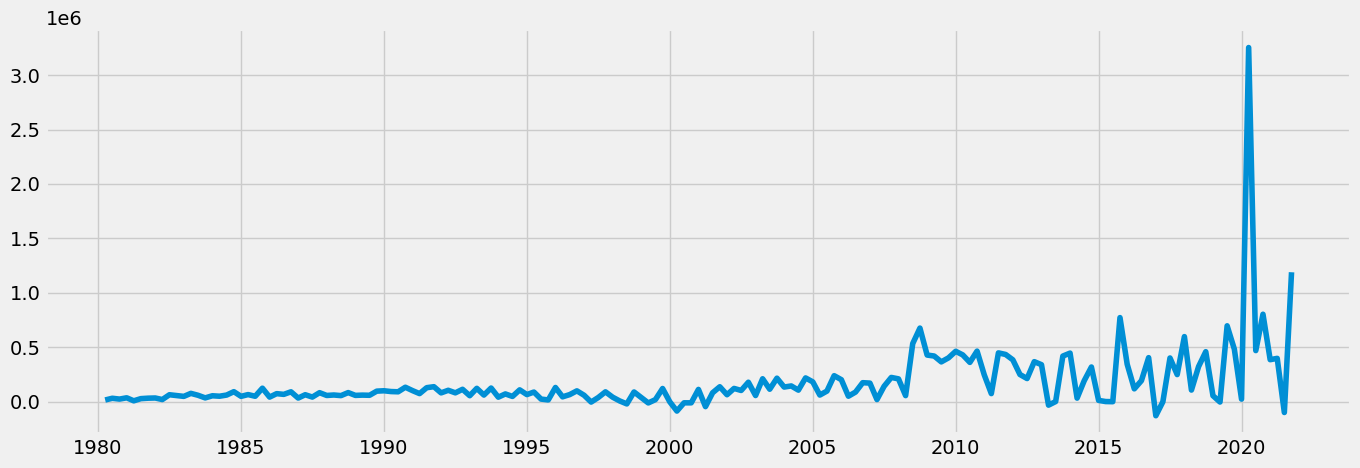

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.227552
p-value                          0.935157
Number of Lags Used             13.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


The new Dickey-Fuller test results after trying to stationarize the dataset show a test statistic of -0.227552, which is still higher than all the critical values (-3.473830, -2.880623, -2.576945). The p-value is 0.935157, which is much higher than 0.05. This means we still fail to reject the null hypothesis, indicating that the data is not stationary even after the attempted stationarization.

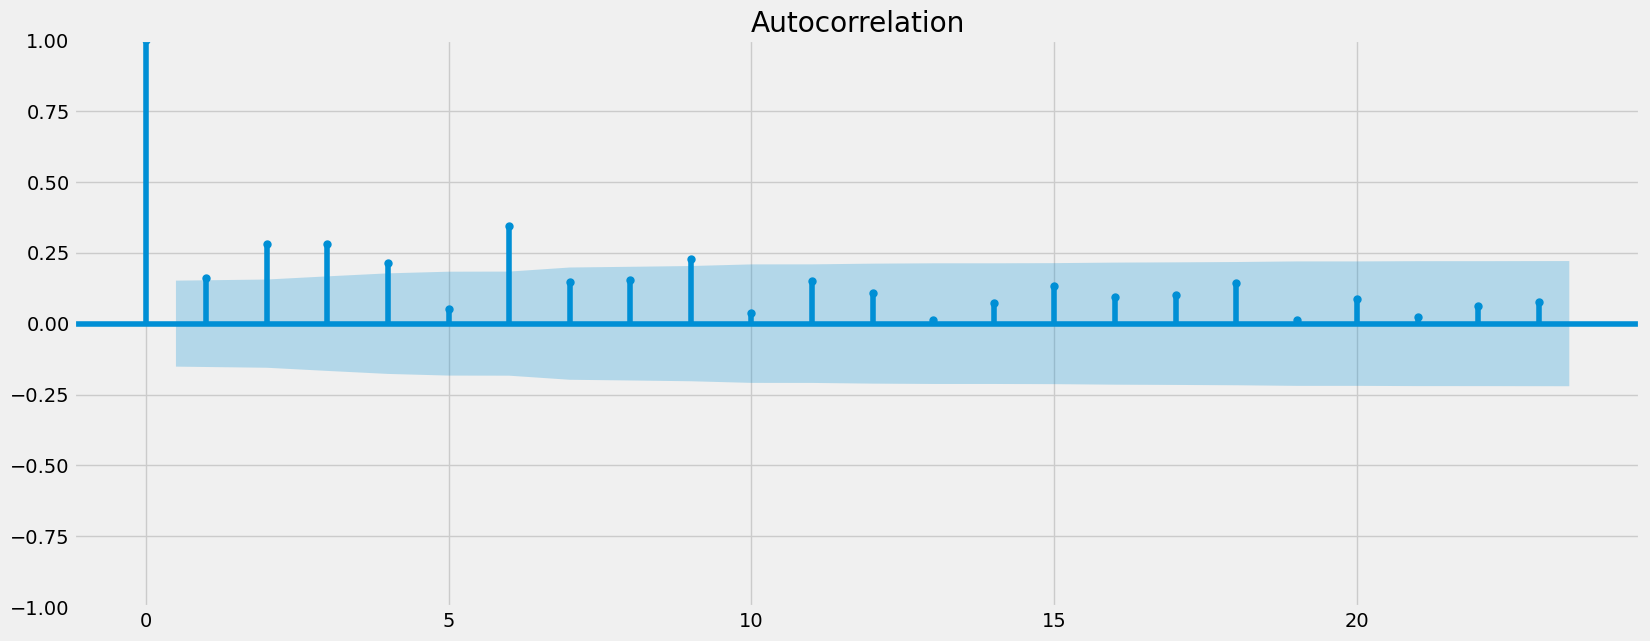

In [34]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot after attempting to stationarize the dataset shows a significant spike at lag 1 and quickly decreases, with most values falling within the confidence interval. This indicates some improvement, but the persistence of significant autocorrelation suggests that the data is still not fully stationary, supporting the Dickey-Fuller test result that the series remains non-stationary.

### Second round of differencing

In [35]:
data_diff2 = data_diff - data_diff.shift(1)

In [36]:
data_diff2.dropna(inplace = True)

In [37]:
data_diff2.head()

,Value
datetime,
1980-07-01,15924.0
1980-10-01,-7578.0
1981-01-01,11812.0
1981-04-01,-27678.0
1981-07-01,20038.0


In [39]:
data_diff2.columns

Index(['Value'], dtype='object')

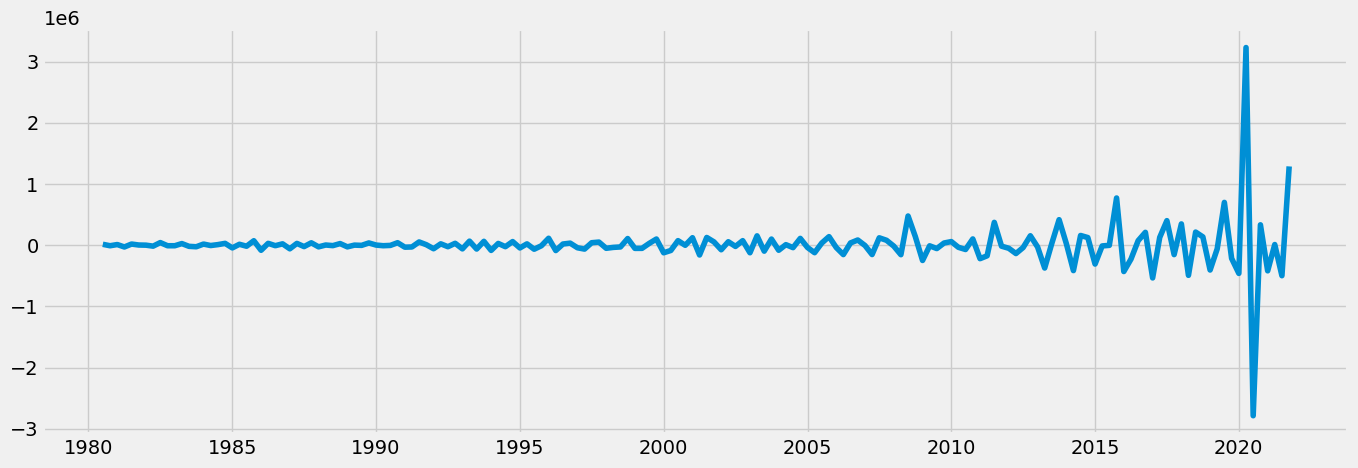

In [40]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [41]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.728423
p-value                          0.069248
Number of Lags Used             14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


The new Dickey-Fuller test results after another differencing show a test statistic of -2.728423, which is still higher than the critical values at 1% (-3.474416), 5% (-2.880878), and 10% (-2.577081). The p-value is 0.069248, which is slightly above the 0.05 threshold. This means we still fail to reject the null hypothesis at the 5% level, but it is close, indicating the data is approaching stationarity.

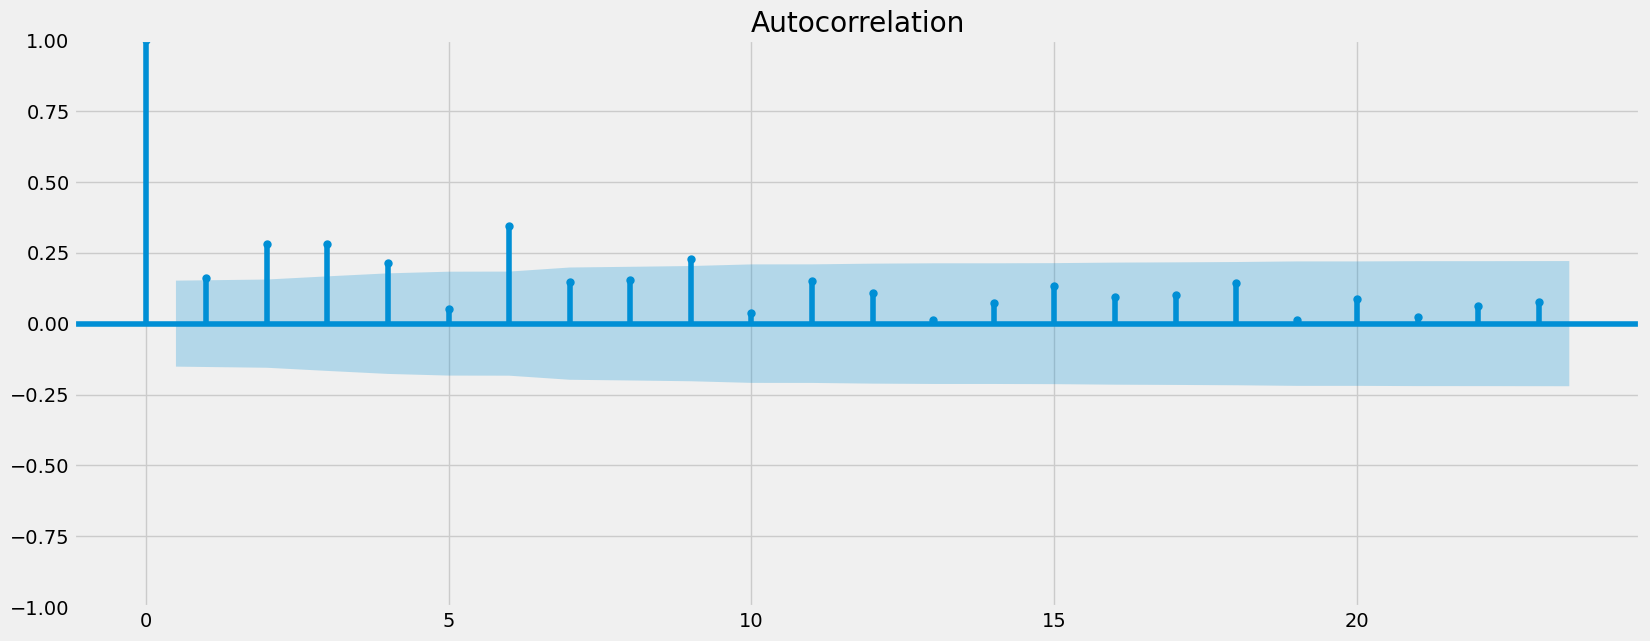

In [42]:
plot_acf(data_diff)
plt.show()